Loaded shape: (784, 4)


,timestamp,safe_gas,propose_gas,fast_gas
0,2025-06-16 08:17:03,0.848937,0.898937,0.980513
1,2025-06-16 08:18:04,0.779819,0.814163,0.895580
2,2025-06-16 08:19:05,0.922407,1.014647,1.116112
3,2025-06-16 08:20:06,0.939530,0.989530,1.062713
4,2025-06-16 08:21:06,0.896778,0.897066,0.975778


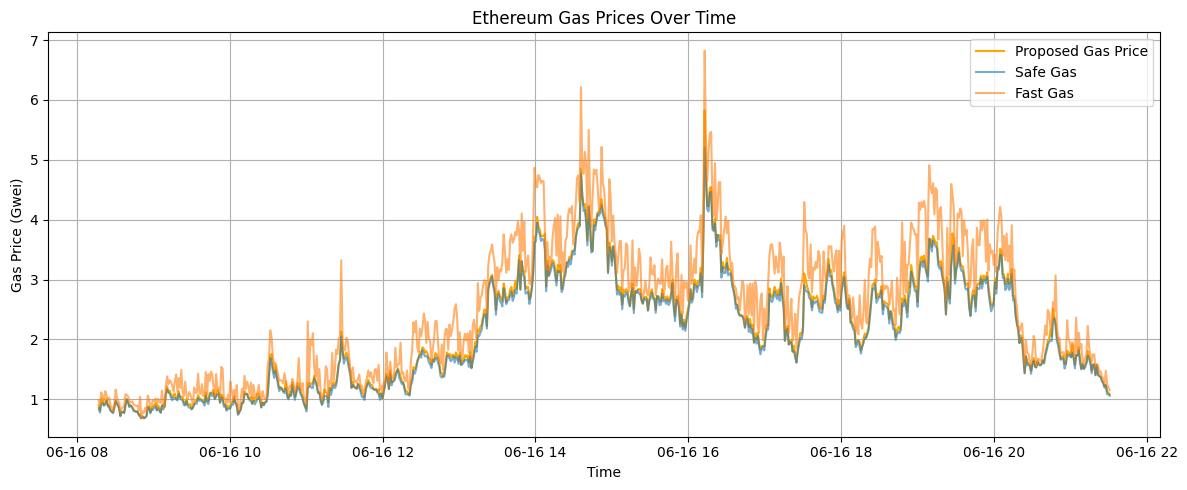

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/gas_log.csv')  
print("Loaded shape:", df.shape)

# timestamp to datetime conversion
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp')

display(df.head())

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['propose_gas'], label='Proposed Gas Price', color='orange')
plt.plot(df['timestamp'], df['safe_gas'], label='Safe Gas', alpha=0.6)
plt.plot(df['timestamp'], df['fast_gas'], label='Fast Gas', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Gas Price (Gwei)')
plt.title('Ethereum Gas Prices Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest MAE: 0.14 gwei
MLP MAE: 0.19 gwei


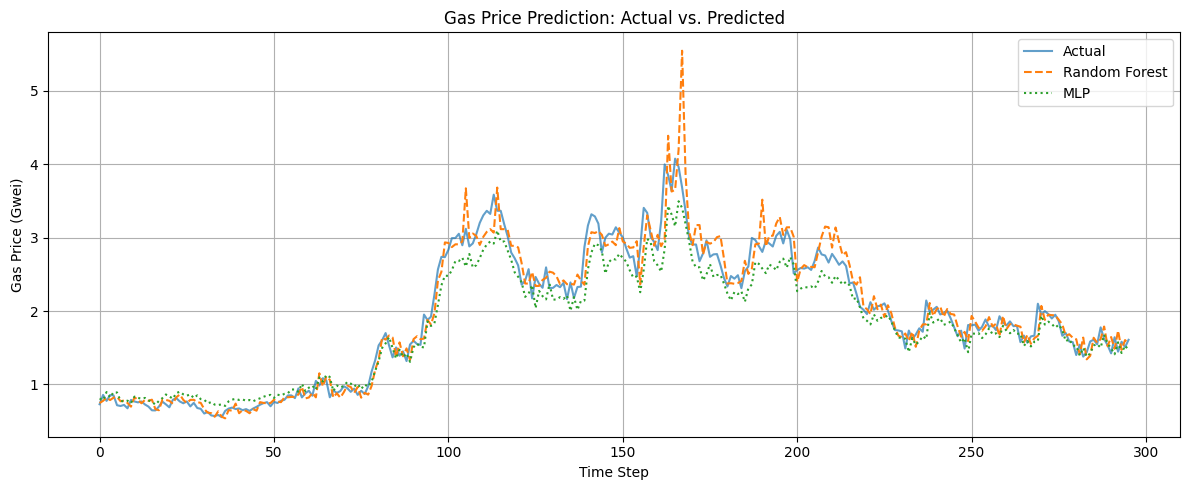

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# data loading and processing
filepath = 'gas_log.csv'  
df = pd.read_csv(filepath)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# feature engineering
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['target'] = df['propose_gas'].shift(-1)
df = df.dropna()

features = ['propose_gas', 'hour', 'dayofweek']
X = df[features]
y = df['target']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest MAE: {rf_mae:.2f} gwei")
joblib.dump(rf_model, 'rf_model.pkl')

# mlp
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                         solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
mlp_preds = mlp_model.predict(X_test_scaled)
mlp_mae = mean_absolute_error(y_test, mlp_preds)
print(f"MLP MAE: {mlp_mae:.2f} gwei")
joblib.dump(mlp_model, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# comparison plot
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(rf_preds, label='Random Forest', linestyle='--')
plt.plot(mlp_preds, label='MLP', linestyle=':')
plt.legend()
plt.title("Gas Price Prediction: Actual vs. Predicted")
plt.xlabel("Time Step")
plt.ylabel("Gas Price (Gwei)")
plt.grid(True)
plt.tight_layout()
plt.show()
